In [2]:
import numpy as np
from scipy.optimize import brute
import csv
import random
import matplotlib.pyplot as plt
import copy
import math
import pandas as pd

# Inputs

In [3]:
parkingLotSize = 173
installCost = 1000
rebatePercent = 0.5 #Assuming that we will get % of all rebates applied for
marketPrice = 2.50 #Average cost of EV charging in Vancouver per hour
hydroPrice = 0.0981 #Dollars per kWhour https://app.bchydro.com/accounts-billing/rates-energy-use/electricity-rates/business-rates.html
markup = 0.05 #Dollars per kWhour
weeks = 522 #10 years
batteryEnergy = 57 #kWh, small SUV, BEV200, 2015
batteryPower = 157 #kW, small SUV, BEV200, 2015

# Data

In [4]:
# Open the CSV file
csv_file = open('time_demand.csv', 'r')
csv_file2 = open('vehicle_registration_2022.csv', 'r')
csv_file3 = open('rebates.csv', 'r')

# Create a csv.reader object
csv_reader = csv.reader(csv_file)
csv_reader2 = csv.reader(csv_file2)
csv_reader3 = csv.reader(csv_file3)

# Initialize an empty array to store the CSV data
data_array = []
data_array2 = []
data_array3 = []

# Read and store data row by row
for row in csv_reader:
    data_array.append(row)
for row in csv_reader2:
    data_array2.append(row)
for row in csv_reader3:
    data_array3.append(row)

# Close the CSV file
csv_file.close()
csv_file2.close()
csv_file3.close()

demandHourly = [item for sublist in [row[1:] for row in data_array[1:-1]] for item in sublist]
vehicleRegistration2022 = data_array2
rebates = data_array3

# Model functions

In [5]:
#Need a script that calculates percent of vehicles in area that are EVs based on vehicle registration data
#Defines variable percentEV

# Specify the column index you want to analyze
column_index = 3  # 3 corresponds to EV included
target_text = "Yes"
count_matches = 0

# Iterate through the rows and check for matches
for row in vehicleRegistration2022[1:]:  # Skip the header row
    if row[column_index] == target_text:
        count_matches += 1

# Calculate the percentage
total_rows = len(vehicleRegistration2022) - 1  # Subtract 1 to exclude the header row
percentEV = count_matches / total_rows
percentEV

0.03045657988467897

In [6]:
def chargingDemand(demandHourly,percentEV,chargerCount,parkingLotSize):
    #Takes inputs: array demandHourly which is 13 (hours per day) by 7 (days per week), float percentEV, float chargingProbability
    #Returns total number of charging instances per week weeklyChargeCount
    
    chargerCount = round(chargerCount)
    weeklyChargeCount = 0
    randomCarArray = []
    chargers = [[False,"",""]]*chargerCount
    chargersFilled = [chargers]
    falses = []
    chargersOccupied = 0
    for i in demandHourly:
        
        parkingSpots = [False,"",""]*(173 - chargerCount)
        chargers = sorted(chargers, key=lambda x: not x[0])
        
        #Cars leaving/staying at chargers:
        for k, car in enumerate(chargers):
            if car[0] and car[2] >= 100:
                chargers[k] = [False,"",""]
                chargersOccupied -= 1
            #ASSUMING CAR CHARGES TO 100%
            elif car[0] and car[2] < 100:
                #car will charge (ASSUMING 20% PER HOUR - CORRECT LATER)
                chargers[k][2] += 20
                
        #Sort chargers so filled comes first
        chargers = sorted(chargers, key=lambda x: not x[0])
                
        for j, car in enumerate(parkingSpots):
            randomCar = generateCar(float(i),percentEV)
            randomCarArray.append(randomCar)
            #if random car is EV that wants to charge:
            if randomCar[1] and randomCar[2] < 40 and chargersOccupied < chargerCount:
                #car will charge (ASSUMING 20% PER HOUR - CORRECT LATER)
                randomCar[2] += 20
                #car parks in charger spot
                chargers = sorted(chargers, key=lambda x: not x[0])
                chargers[chargersOccupied] = randomCar
                chargersOccupied += 1
            else:
                #car parks in regular spot
                parkingSpots[j] = randomCar
                
        chargersFilled.append(copy.deepcopy(chargers))
        
        weeklyChargeCount += chargersOccupied
    return(weeklyChargeCount,chargersFilled)


In [7]:
def generateCar(demand,percentEV):
    #generates a Car: array of length 3 [does the car exist?,is the car an EV?,SOC]
    #to do: add additional car properties
    #if the spot is empty (random number is above % chance that spot is filled)
    car = [False,"",""]
    if random.randint(1, 100) > (demand*100):
        return car
    #if car is EV
    elif random.randint(1, 100) < (percentEV*100):
        car[0] = True
        car[1] = True
        car[2] = random.randint(20, 80)
    else:
        car[0] = True
        car[1] = False
    
    return car

# counttest = 100
# test = []
# while counttest > 0:
#     test.append(generateCar(0.5,0.1))
#     counttest -= 1
# test

In [8]:
chargingDemand(demandHourly,percentEV,3,parkingLotSize)[0]

262

In [9]:
def powerToHour(markup,power,hydroPrice):
    #Calculates the price per hour based on price per kWh
    markupHour = markup*power #$/kWh * kW = $/h
    priceHour= (hydroPrice+markup)*power
    return(priceHour,markupHour)

#NOTE: Charger quote is from Chargepoint and is currently hardcoded into the function below (change this later):

In [10]:
def profit(installCost,rebatePercent,weeks,demandHourly,percentEV,chargers,parkingLotSize,hydroPrice,marketPrice,markup,power):
    #Takes inputs: float installCost in CAD, float rebatePercent, chargeCharge in CAD/hour (change this eventually to CAD/kWh and weeklyChargeCount to kwH/week)
    #plus params for ChargingDemand
    hourlyPrice = powerToHour(markup,power,hydroPrice)[0]
    hourlyProfit = powerToHour(markup,power,hydroPrice)[1]
    if marketPrice < hourlyPrice:
        demandScale = marketPrice/hourlyPrice
    else:
        demandScale = 1
    
    revenue = 0
    revenueWeekly = []
    if power <= 7.2:
        chargerCost = 11500
    elif 7.2 < power <= 20:
        chargerCost = 18000
    else:
        chargerCost = 100000
    costsBeforeRebate = (installCost+chargerCost)*chargers
    [rebateAmount,rebateMax] = rebate(float(power))
    if costsBeforeRebate*(1-rebateAmount) > rebateMax:
        costs = costsBeforeRebate-(rebateMax*rebatePercent)
    else:
        rebateAmount = 1-((1-rebateAmount)*rebatePercent)
        costs = costsBeforeRebate * rebateAmount
    #This needs to be adjusted for inflation later
    #efficiency
    demand = np.mean([chargingDemand(demandHourly,percentEV,chargers,parkingLotSize)[0] for i in range(5)])
    while weeks > 0:
        weekRevenue = demand* hourlyProfit * demandScale
        revenue += weekRevenue
        revenueWeekly.append(revenue)
        weeks -= 1
    print("done")
    return(revenue-costs,revenueWeekly,costs,costsBeforeRebate)
    #Returns total profit/loss in CAD

In [11]:
def rebate(power):
    #Based on charger power, returns maximum rebate percentage and maximum rebate in dollars
    percentPaid = 1
    rebateMax = 0
    usedRebate = ""
    for i in rebates[1:]:
        if i[0] != usedRebate and (float(i[1]) >= float(power)) and (float(power) <= float(i[2])):
            usedRebate = i[0]
            percentPaid *= (1-float(i[3]))
            rebateMax += float(i[4])
    return(percentPaid,rebateMax)

In [12]:
def chargerSizing(installCost,rebatePercent,weeks,demandHourly,percentEV,parkingLotSize,hydroPrice,marketPrice,markup):
    #This is an optimization function that finds the optimal number of chargers to maximize profit

    def profitMin(vars):
        x, y = vars
        return(-profit(installCost,rebatePercent,weeks, demandHourly,percentEV,x,parkingLotSize,hydroPrice,marketPrice,markup, y)[0])
    
    # Define the ranges for each parameter
    param_ranges = (slice(2, 16, 2), slice(7.2, 100, 6.4))  # Example ranges, adjust as needed

    # Use brute force to minimize the profit function
    result = brute(profitMin, param_ranges, full_output=True, finish=None)

    chargers = result[0][0]
    power = result[0][1]
    netprofit = -result[1]
    return(chargers, power)

In [13]:
optimal = chargerSizing(installCost,rebatePercent,weeks,demandHourly,percentEV,parkingLotSize,hydroPrice,marketPrice,markup)
optimal

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


(10.0, 20.0)

In [283]:
options = [[2,7.2],[2,20]
          ,[4,7.2],[4,20]
          ,[6,7.2],[6,20]
          ,[8,7.2],[8,20],[10,20]]

chargers = []
power = []
unique_id = []
weekNumber = []
totalProfit = []
weeklyProfit = []
costAfterRebate = []
costBeforeRebate = []

for i in options:
    chargers.append(i[0])
    power.append(i[1])
    unique_id.append(f"{i[0]}c{i[1]}kW")
    weekNumber.extend(range(1,weeks+1))
    revenueData = profit(installCost,rebatePercent,weeks,demandHourly,percentEV,i[0],parkingLotSize,hydroPrice,marketPrice,markup,i[1])
    totalProfit.append(revenueData[0])
    weeklyProfit.extend(revenueData[1])
    costAfterRebate.append(revenueData[2])
    costBeforeRebate.append(revenueData[3])

# We're going to have the same unique id, charger number and power for all listed weeks in the profit tab
# These values will change every 522 rows, so reorganize lists to reflect this pattern
duplicateValues = list(np.ones(len(options), dtype=int)*weeks)
unique_id_profit = [x for x, number in zip(unique_id, duplicateValues) for _ in range(number)]
chargers_profit = [x for x, number in zip(chargers, duplicateValues) for _ in range(number)]
power_profit = [x for x, number in zip(power, duplicateValues) for _ in range(number)]

# Create dataframe for the weekly profit tab
profitData = {}
profitData["Unique ID"] = unique_id_profit
profitData["Number of chargers"] = chargers_profit
profitData["Power"] = power_profit
profitData["Week"] = weekNumber
profitData["Profit"] = weeklyProfit
weeklyExcel = pd.DataFrame(profitData)

# Create dataframe for the summary tab
summaryData = {}
summaryData["Unique ID"] = unique_id
summaryData["Number of chargers"] = chargers
summaryData["Power"] = power
summaryData["Total profit"] = totalProfit
summaryData["Cost after Rebates"] = costAfterRebate
summaryData["Cost before Rebates"] = costBeforeRebate
summaryExcel = pd.DataFrame(summaryData)

done
done
done
done
done
done
done
done
done


In [177]:
# Specify the file name
file_name = "testOutput.xlsx"

# Populate the Excel file with the dataframes defined earlier
with pd.ExcelWriter(file_name) as excelFile:
    summaryExcel.to_excel(excelFile, sheet_name='Summary', index=False)
    weeklyExcel.to_excel(excelFile, sheet_name='Profit over time', index=False)


print(f"The data has been written to {file_name}.")

The data has been written to results_rebate_half.csv.


## Graph tool for initial report - delete later

179505.2329507101


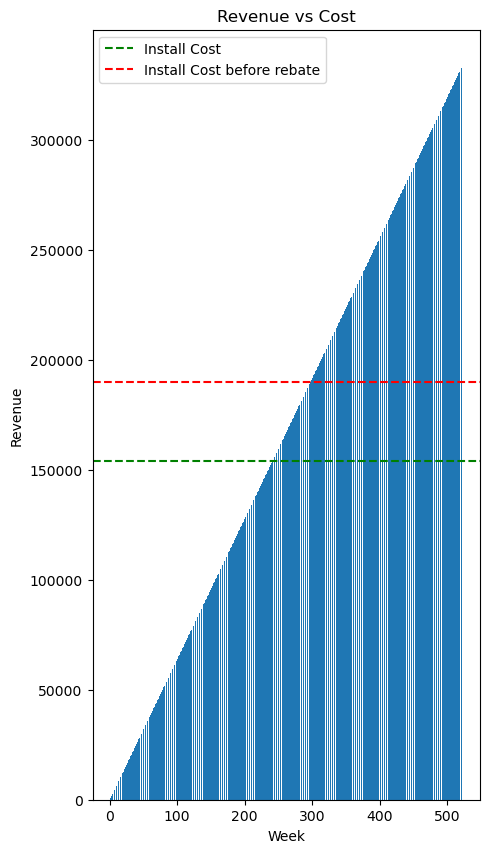

In [284]:
run = -1
print(revenueWeekly[run][0][0])
# Create the bar graph with position-based labels
plt.figure(figsize=(5, 10))
plt.bar(range(1, len(revenueWeekly[run][0][1]) + 1), revenueWeekly[run][0][1])

# Add a horizontal line at y=installCost
plt.axhline(y=revenueWeekly[run][0][2], color='green', linestyle='--', label='Install Cost')
plt.axhline(y=revenueWeekly[run][0][3], color='red', linestyle='--', label='Install Cost before rebate')

# Set the title and labels for the axes
plt.title('Revenue vs Cost')
plt.xlabel('Week')
plt.ylabel('Revenue')

# Display the legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
#num = number of chargers, char_type = charger type (1=[0],2=[1],3=[2]),power_cons = KW consumption of each charger, years 
import numpy as np
type_still_bank = [150,200,300]
type_wear_bank = [0.02,0.03,0.04]
def sustain_func(num,char_type,power_cons,years=10):
    if num != len(char_type):
        print("sustain_func: num and type are not the same len")
    elif num != len(char_type):
        print("sustain_func: num and power_cons are not the same len")
    else:
        seasons = years * 4
        type_still_act = np.zeros([len(type_still_bank),seasons])
        type_wear_act = np.zeros([len(type_wear_bank),seasons])
        adjust_factor = np.array([1,1.1,1.4,1.1])
        for i in range(len(char_type)):
            for j in range(seasons):
                season_index = j%4
                type_still_act[i,j] = type_still_bank[i]*adjust_factor[season_index]
                type_wear_act[i,j] = type_wear_bank[i]*adjust_factor[season_index]
                #if 0,4,8,12 its summer
                #if 1,5,9,13 its fall
                #if 2,6, 10,14 its winter
                #if 3,7,11,15 its spring    
        cost_total = sum(type_still_act)+sum(type_wear_act)
    return(sum(cost_total))
          
print(sustain_func(3,[1,2,1],[100,200,150],years=10))   

In [15]:
def EVDemandIncrease(markup,chargers):
    #returns the % increase in EV sales given electricity price markup and number of chargers installed
    coeffs = {
        1:[0.1997,-0.032]
        ,2:[0.1997,-0.032]
        ,3:[0.1997,-0.032]
        ,4:[0.2193,-0.031]
        ,5:[0.2193,-0.031]
        ,6:[0.2193,-0.031]
        ,7:[0.227,-0.028]
        ,8:[0.227,-0.028]
        ,9:[0.227,-0.028]
        ,10:[0.2325,-0.027]
        ,11:[0.2325,-0.027]
        ,12:[0.236,-0.026]
        ,13:[0.236,-0.026]
        ,14:[0.2405,-0.025]
        ,15:[0.2405,-0.025]
        ,16:[0.2405,-0.025]
    }
    if coeffs[chargers][0]*math.exp(coeffs[chargers][1]*markup) < 0.16:
        increase = 0.1
    else:
        increase = coeffs[chargers][0]*math.exp(coeffs[chargers][1]*markup) - 0.16
    return(increase)

# Carbon emissions

In [22]:
#INPUTS
percentEVSales = EVDemandIncrease(markup,optimal[0])*100
numberOfChargers = optimal[0]
#Average kilometers driven per year in BC is 13,100kms
kmDriven = 13100
evSales = 18 #Percent, From https://dailyhive.com/vancouver/bc-electric-vehicle-sales-uptake-2022-statistics

In [23]:
percentEVSales

7.218633677031764

In [24]:
Vehicles = pd.read_csv('Copy of Vehicle Population - 2022 Passenger Vehicles_Full _data.csv')
EmissionsFactors = pd.read_csv('EmissionsFactorsTechscape.csv')
SizeMap = pd.read_csv('SizeMap.csv')
vehicleSales2022 = pd.read_csv('ev_sales_2022.csv')

# Q4 2022 car sales in BC
carSales = int(vehicleSales2022.query("Month=='Total'")["Unit Sales"])
bcPopulationPercent = 662248 / 39498018  # Vancouver pop / canada pop
#Removed BC population 5403528 replaced with Vancouver
vanCarSales = math.ceil(carSales * bcPopulationPercent)
vanCarSales

#Need to calculate baseline % of vehicles that are EV/gas
#Then use study values to get % increase/decrease for 2035
isEV_counts = Vehicles['Electric Vehicle Included'].value_counts()
percentReplaced = vanCarSales/sum(isEV_counts)
percentageEV = (isEV_counts['Yes'] / len(Vehicles)) * 100
percentageICE = 100 - percentageEV
salesIncreasePerYear = (100-18)/(2035-2023) #Assuming increase in EV purchases is linear and 100% of new purchases are EVs by 2035
percentageEV2035 = percentageEV
for i in range(2035-2023):
    if percentageEV2035 < 100:
        percentageEV2035 = percentReplaced * (evSales + i*salesIncreasePerYear) + (1-percentReplaced) * percentageEV2035
    else:
        pass
percentageICE2035 = 100 - percentageEV2035
ICEadjustmentFactor2035 = percentageICE2035/percentageICE
EVadjustmentFactor2035 = percentageEV2035/percentageEV
percentageEV2035

#Gas vehicles baseline

VehiclesMapped = Vehicles.merge(SizeMap, on='Body Style', how='left')
GasVehiclesEmissions = VehiclesMapped.merge(EmissionsFactors[EmissionsFactors['Powertrain type'] == 'Gasoline'], on='Size', how='left')
GasVehiclesEmissions = GasVehiclesEmissions[GasVehiclesEmissions['Electric Vehicle Included'] == 'No']
GasBaselineEmissions_WTP = GasVehiclesEmissions.groupby('Size')['Well to pump emissions (g/km)'].sum().reset_index()
GasBaselineEmissions_PTW = GasVehiclesEmissions.groupby('Size')['Pump to wheel emissions (g/km)'].sum().reset_index()

GasBaselineEmissions_WTP

GasBaselineEmissions_PTW

GasBaselineEmissions_WTP2035 = GasBaselineEmissions_WTP['Well to pump emissions (g/km)'] * ICEadjustmentFactor2035
GasBaselineEmissions_PTW2035 = GasBaselineEmissions_PTW['Pump to wheel emissions (g/km)'] * ICEadjustmentFactor2035

#EVs Baseline

EVBaselineEmissions = VehiclesMapped.merge(EmissionsFactors[EmissionsFactors['Powertrain type'] == 'EV'], on='Size', how='left')
EVBaselineEmissions = EVBaselineEmissions[EVBaselineEmissions['Electric Vehicle Included'] == 'Yes']
EVBaselineEmissions_WTP = EVBaselineEmissions.groupby('Size')['Well to pump emissions (g/km)'].sum().reset_index()
EVBaselineEmissions_PTW = EVBaselineEmissions.groupby('Size')['Pump to wheel emissions (g/km)'].sum().reset_index()

EVBaselineEmissions_WTP2035 = EVBaselineEmissions_WTP['Well to pump emissions (g/km)'] * EVadjustmentFactor2035
EVBaselineEmissions_PTW2035 = EVBaselineEmissions_PTW['Pump to wheel emissions (g/km)'] * EVadjustmentFactor2035

#Baseline in one dataframe (g/km driven)

BaselineEmissions = pd.concat([GasBaselineEmissions_WTP,
                               GasBaselineEmissions_PTW['Pump to wheel emissions (g/km)'],
                               GasBaselineEmissions_WTP2035, GasBaselineEmissions_PTW2035,
                               EVBaselineEmissions_WTP['Well to pump emissions (g/km)'], EVBaselineEmissions_PTW['Pump to wheel emissions (g/km)'],
                               EVBaselineEmissions_WTP2035, EVBaselineEmissions_PTW2035], axis = 1)
BaselineEmissions.columns = ['Size', 'Gas WTP', 'Gas PTW', 'Gas WTP 2035', 'Gas PTW 2035', 'EV WTP', 'EV PTW', 'EV WTP 2035', 'EV PTW 2035']
BaselineEmissions

#Project Emissions

salesIncreasePerYearProject = (100-18+percentEVSales)/(2035-2023)
percentageEV2035Project = percentageEV
for i in range(2035-2023):
    if percentageEV2035Project < 100:
        percentageEV2035Project = percentReplaced * (evSales + i*salesIncreasePerYearProject) + (1-percentReplaced) * percentageEV2035Project
    else:
        pass
percentageICE2035Project = 100 - percentageEV2035Project
ICEadjustmentFactor2035Project = percentageICE2035Project/percentageICE
EVadjustmentFactor2035Project = percentageEV2035Project/percentageEV
percentageEV2035Project

#Gas vehicles project

GasProjectEmissions_WTP2035 = GasBaselineEmissions_WTP['Well to pump emissions (g/km)'] * ICEadjustmentFactor2035Project
GasProjectEmissions_PTW2035 = GasBaselineEmissions_PTW['Pump to wheel emissions (g/km)'] * ICEadjustmentFactor2035Project

#EVs project

EVProjectEmissions_WTP2035 = EVBaselineEmissions_WTP['Well to pump emissions (g/km)'] * EVadjustmentFactor2035Project
EVProjectEmissions_PTW2035 = EVBaselineEmissions_PTW['Pump to wheel emissions (g/km)'] * EVadjustmentFactor2035Project

#Charger lifecycle project

chargerLifecycle = 4737.6 + 71.0 + 86.3 + 3310.7 #Production, transportation, installation, and recycling in kg CO2
totalChargerEmissions = numberOfChargers * chargerLifecycle #in kg CO2
totalChargerEmissions

#TOTAL

totalBaseline = (sum(EVBaselineEmissions_WTP2035) + sum(EVBaselineEmissions_WTP2035) + sum(GasBaselineEmissions_WTP2035) + sum(GasBaselineEmissions_PTW2035))*13100/1000
totalProject = (sum(EVProjectEmissions_WTP2035) + sum(EVProjectEmissions_WTP2035) + sum(GasProjectEmissions_WTP2035) + sum(GasProjectEmissions_PTW2035))*13100/1000
netCarbon = totalProject + totalChargerEmissions - totalBaseline
AllEmissions = pd.concat([BaselineEmissions
                         ,GasProjectEmissions_WTP2035
                         ,GasProjectEmissions_PTW2035
                         ,EVProjectEmissions_WTP2035
                         ,EVProjectEmissions_PTW2035], axis = 1)
AllEmissions.columns = ['Size', 'Gas WTP', 'Gas PTW', 'Gas WTP 2035 Baseline', 'Gas PTW 2035 Baseline', 'EV WTP', 'EV PTW', 'EV WTP 2035 Baseline', 'EV PTW 2035 Baseline', 'Gas WTP 2035 Project', 'Gas PTW 2035 Project', 'EV WTP 2035 Project', 'EV PTW 2035 Project']
print("The net CO2 reduction in 2035 is "+str(netCarbon)+" kg CO2e")
AllEmissions

The net CO2 reduction in 2035 is -8353124.765914366 kg CO2e


C:\Users\yhedg\AppData\Local\Temp\ipykernel_32796\562990176.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  carSales = int(vehicleSales2022.query("Month=='Total'")["Unit Sales"])


,Size,Gas WTP,Gas PTW,Gas WTP 2035 Baseline,Gas PTW 2035 Baseline,EV WTP,EV PTW,EV WTP 2035 Baseline,EV PTW 2035 Baseline,Gas WTP 2035 Project,Gas PTW 2035 Project,EV WTP 2035 Project,EV PTW 2035 Project
0,Compact,3.722830e+05,1.555670e+06,78159.262872,3.266065e+05,2140.629078,0.0,55978.073488,0.0,57284.062374,239374.639123,59799.143065,0.0
1,High midsize,9.420564e+05,3.939465e+06,197780.779958,8.270742e+05,32233.089340,0.0,842904.668849,0.0,144956.414879,606174.698984,900441.436129,0.0
2,Midsize,5.069035e+05,2.128053e+06,106422.251382,4.467758e+05,23341.866855,0.0,610396.612767,0.0,77998.418385,327448.502944,652062.354049,0.0
3,Pickup,1.958070e+04,8.197333e+04,4110.885269,1.720996e+04,55.923546,0.0,1462.417014,0.0,3012.927701,12613.427917,1562.241764,0.0
4,Small SUV,1.505609e+06,6.272717e+06,316096.185567,1.316931e+06,33971.690262,0.0,888369.589049,0.0,231671.499256,965197.622830,949009.796884,0.0
